In [1]:

DIST_PATH = 'evaluation/dtw/userAcceleration-y_distances.npy'
DATA_PATH = 'data/motionsense.csv'

In [2]:
# TODO: procurar nomes melhores
CLASS_MAP = ["dws","ups", "wlk", "jog", "std", "sit"]

In [3]:
LABEL = 'dws'

# Carregando distâncias e rótulos

In [4]:
import pandas as pd
import numpy as np
from scripts.compute_distances import get_series

In [5]:
data_df = pd.read_csv(DATA_PATH, index_col=0)

In [6]:
X, labels = get_series(data_df, 'userAcceleration.y') # da para passar qualquer coluna aqui, estamos apenas interessados nos labels

In [7]:
# convertendo ids para labels strings
labels = np.array([CLASS_MAP[int(i)] for i in labels])

In [8]:
distances = np.load(DIST_PATH)

# Agregando distâncias com base nos rótulos

In [9]:
def agregate_distances_by_label(target_label: int, distances: np.array, labels: np.array):

    distances_by_label = {}
    same_label_ids = np.where(labels == target_label)[0]

    for label in np.unique(labels):

        different_label_ids = np.where(labels == label)[0]

        # talvez exista uma forma de fazer isso melhor
        distances_by_label[label] = []
        for same_label_id in same_label_ids:
            for different_label_id in different_label_ids:
                curr_dist = distances[same_label_id, different_label_id]
                # ignorar distancias 0 (exemplo para ele mesmo)
                if curr_dist != 0:
                    distances_by_label[label].append(distances[same_label_id, different_label_id])

    return distances_by_label

In [10]:
distance_dict = agregate_distances_by_label('dws', distances, labels)

# Preparando plot

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [12]:
def plot_distances_by_label(distance_dict: dict, label: str):

    all_distances = np.concatenate([dists for dists in distance_dict.values()])
    all_labels = np.concatenate([[label] * len(dists) for label, dists in distance_dict.items()])


    ax = sns.boxplot(y=all_distances, x=all_labels, palette='tab10', hue=all_labels, legend=False)
    plt.suptitle(f"Distâncias entre a classe '{label}' e as outras classes")
    ax.set(xlabel='Classe', ylabel='Distância')
    # TODO: salvar a figurinha

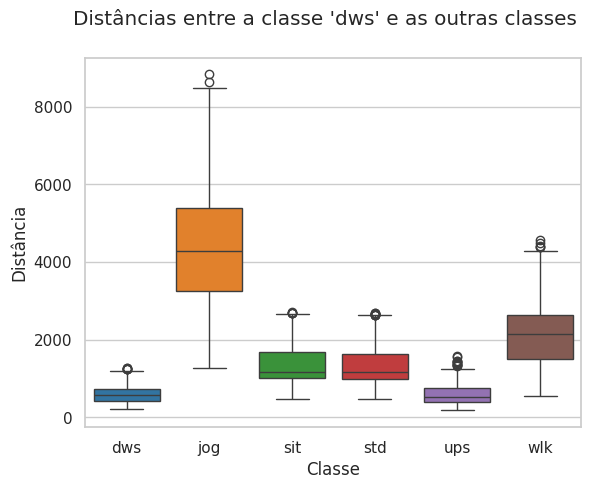

In [13]:
distance_dict = agregate_distances_by_label(LABEL, distances, labels)
plot_distances_by_label(distance_dict, LABEL)

# Determinando pares de séries mais semelhantes e diferentes por label

In [14]:
import matplotlib.pyplot as plt

In [15]:
import pandas as pd

def calculate_moving_average(series: np.array, window: int = 10) -> np.array:

    series = pd.Series(series)
    moving_average = series.rolling(window).mean()

    return moving_average.values


In [16]:
calculate_moving_average(X[0])

array([       nan,        nan,        nan, ..., -0.1273031, -0.1606723,
       -0.2404768])

In [43]:
def standardize_series(series: np.array) -> np.array:
    
    mean = series.mean()
    std = series.std()

    return (series - mean) / std

def plot_pair_of_series(distances: np.array, label: str, most_similar: bool = True, window: int = 10, offset: int = 2, standardize: bool = False):

    plt.suptitle(f"Séries {'mais' if most_similar else 'menos'} similares da classe '{label}'.")

    if most_similar:
        # distancia 0 para o proprio exemplo não tem graça
        distances = distances.copy()
        distances[distances == 0.0] = np.inf

    label_ids =  np.where(labels == label)[0]
    label_distances = distances[label_ids][:,label_ids]
    print(f'- Min: {label_distances.min()}')
    print(f'- Max: {label_distances.max()}')
    i, j = np.unravel_index(label_distances.argmin() if most_similar else label_distances.argmax(), label_distances.shape)
    print(labels[label_ids[j]], labels[label_ids[i]])
    plt.plot(calculate_moving_average(standardize_series(X[label_ids[j]]) if standardize else X[label_ids[j]], window=window))
    plt.plot(calculate_moving_average(standardize_series(X[label_ids[i]]) if standardize else X[label_ids[i]], window=window) + offset)


- Min: 0.0
- Max: 3598.488202598638
wlk wlk


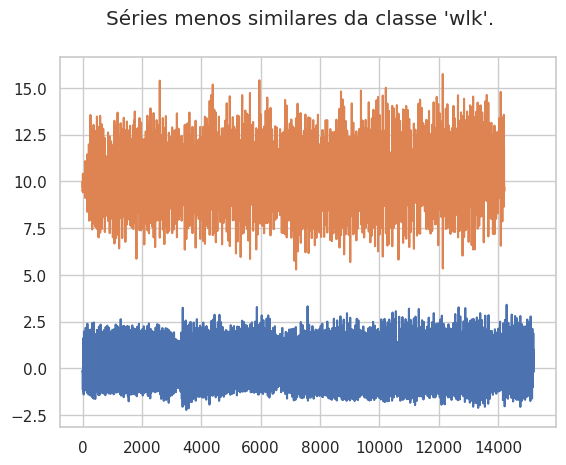

In [45]:
plot_pair_of_series(distances, 'wlk', most_similar=False, window=1, offset=10, standardize=True)

- Min: 0.0
- Max: 6.778091438104998
std std


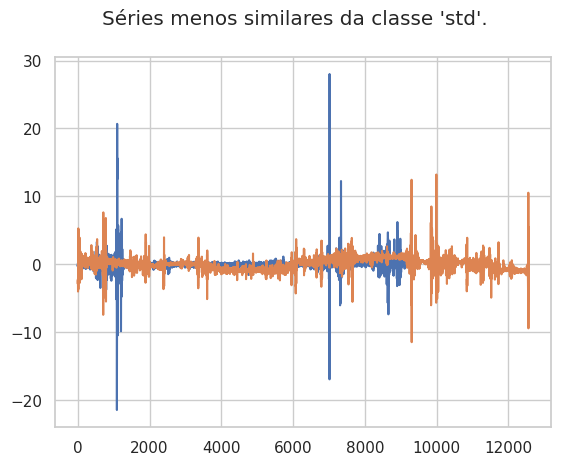

In [39]:
plot_pair_of_series(distances, 'std', most_similar=False, window=1, offset=0)